In [1]:
import numpy as np
import torch
from tensordict import TensorDict
import numba

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 32
seq_len = 200

In [3]:
mask_sensorial_data = 0.5

In [4]:
generator_numpy = np.random.default_rng(0)

In [6]:
def generate_mask():
    sensorial_masks = TensorDict(
                            device=device, batch_size=batch_size)

    for name in ["M", "C"]:
        sensorial_masks[name] = torch.ones(
        (batch_size, seq_len), dtype=bool, device=device)
        
    for sensorial_dim in sensorial_masks.keys():
        for batch_idx in range(batch_size):
            mask = sensorial_masks[sensorial_dim][batch_idx]

            masked_count = (
                mask.shape[0] - mask.sum())/mask.shape[0]

            if masked_count < mask_sensorial_data:
                idxs = torch.argwhere(mask != 0).flatten()
                idxs = idxs.cpu().numpy()

                to_mask_count = (mask.shape[0] *
                                    (mask_sensorial_data-masked_count))
                to_mask_count = int(
                    np.ceil(to_mask_count.cpu().item()))

                to_mask = generator_numpy.choice(
                    idxs, to_mask_count, replace=False)

                sensorial_masks[sensorial_dim][batch_idx][to_mask] = 0

    return sensorial_masks

In [16]:
%timeit generate_mask()

45.1 ms ± 3.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
@numba.njit(parallel=True)
def mask_mask(masks:np.ndarray, mask_pct:float, ):
    for batch_idx in numba.prange(batch_size):
        mask = masks[batch_idx]

        masked_count = (
            mask.shape[0] - mask.sum())/mask.shape[0]

        if masked_count < mask_pct:
            idxs = np.argwhere(mask != 0).flatten()

            to_mask_count = (mask.shape[0] *
                                (mask_pct-masked_count))
            to_mask_count = int(
                np.ceil(to_mask_count))

            to_mask = np.random.choice(
                idxs, to_mask_count, replace=False)
            
            masks[batch_idx][to_mask] = 0

    return masks

In [37]:
def generate_mask_2():
    sensorial_masks = TensorDict(
                            device=device, batch_size=batch_size)

    for name in ["M", "C"]:
        sensorial_masks[name] = torch.ones(
        (batch_size, seq_len), dtype=bool, device=device)
        
    for sensorial_dim in sensorial_masks.keys():
        masks = sensorial_masks[sensorial_dim].cpu().numpy()
        sensorial_masks[sensorial_dim] = torch.tensor(mask_mask(masks, mask_sensorial_data), device=device)

    return sensorial_masks

In [42]:
sensorial_masks = generate_mask_2()

In [43]:
%timeit generate_mask_2()

916 μs ± 81.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [50]:
def generate_mask3():
    sensorial_masks = TensorDict(
                            device=device, batch_size=batch_size)

    for name in ["M", "C"]:
        sensorial_masks[name] = torch.ones(
        (batch_size, seq_len), dtype=bool, device=device)
        
    for sensorial_dim in sensorial_masks.keys():
        for batch_idx in range(batch_size):
            mask = sensorial_masks[sensorial_dim][batch_idx]

            masked_count = (
                mask.shape[0] - mask.sum())/mask.shape[0]

            if masked_count < mask_sensorial_data:
                idxs = torch.argwhere(mask != 0).flatten()

                to_mask_count = (mask.shape[0] *
                                    (mask_sensorial_data-masked_count))
                to_mask_count = torch.ceil(to_mask_count).int()

                to_mask_idxs = torch.randperm(len(idxs))[:to_mask_count]
                to_mask = idxs[to_mask_idxs]

                sensorial_masks[sensorial_dim][batch_idx][to_mask] = 0
    return sensorial_masks

In [54]:
generate_mask3()["M"].sum(axis=1)

tensor([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100], device='cuda:0')

In [ ]:
generate_mask3()["M"].device

device(type='cuda', index=0)

In [55]:
%timeit generate_mask3()

55.4 ms ± 3.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:


def generate_mask4():
    sensorial_masks = TensorDict(batch_size=batch_size,
                            )#device=device)

    for name in ["M", "C"]:
        sensorial_masks[name] = torch.ones(
        (batch_size, seq_len), dtype=bool)#, device=device)
        
    for sensorial_dim in sensorial_masks.keys():
        masks = sensorial_masks[sensorial_dim]

        masked_count = (
            masks.shape[1] - masks.sum(axis=1))/masks.shape[1]
        
        

        idxs = torch.argwhere(masks != 0)

        to_mask_count = (masks.shape[1] *
                            (mask_sensorial_data-masked_count))
        to_mask_count = torch.ceil(to_mask_count).int()
        
        

        to_mask_idxs = torch.randperm(len(idxs))
        
        to_mask = idxs[to_mask_idxs]

        print("masks", masks.shape)
        print("masked_count", masked_count.shape)
        print("masks != 0", (masks != 0).shape)
        print("idxs", idxs.shape)
        print("to_mask_count", to_mask_count.shape)
        print("to_mask_idxs", to_mask_idxs.shape)
        print("to_mask", to_mask.shape)

        sensorial_masks[sensorial_dim][to_mask] = 0
    return sensorial_masks

In [111]:
sensorial_masks = TensorDict(batch_size=batch_size,
                            )#device=device)

for name in ["M", "C"]:
    sensorial_masks[name] = torch.ones(
    (batch_size, seq_len), dtype=bool)#, device=device)
    
for sensorial_dim in sensorial_masks.keys():
    masks = sensorial_masks[sensorial_dim]

    masked_count = (
        masks.shape[1] - masks.sum(axis=1))/masks.shape[1]
    
    

    idxs = torch.argwhere(masks != 0)

    to_mask_count = (masks.shape[1] *
                        (mask_sensorial_data-masked_count))
    to_mask_count = torch.ceil(to_mask_count).int()
    

    to_mask_idxs = torch.randperm(len(idxs))
    
    to_mask = idxs[to_mask_idxs]

    print("masks", masks.shape)
    print("masked_count", masked_count.shape)
    print("masks != 0", (masks != 0).shape)
    print("idxs", idxs.shape)
    print("to_mask_count", to_mask_count.shape)
    print("to_mask_idxs", to_mask_idxs.shape)
    print("to_mask", to_mask.shape)

    sensorial_masks[sensorial_dim][to_mask] = 0

masks torch.Size([32, 200])
masked_count torch.Size([32])
masks != 0 torch.Size([32, 200])
idxs torch.Size([6400, 2])
to_mask_count torch.Size([32])
to_mask_idxs torch.Size([6400])
to_mask torch.Size([6400, 2])


IndexError: index 80 is out of bounds for dimension 0 with size 32

In [120]:
sensorial_masks["C"].shape

torch.Size([32, 200])

In [110]:
generate_mask4()

masks torch.Size([32, 200])
masked_count torch.Size([32])
masks != 0 torch.Size([32, 200])
idxs torch.Size([6400, 2])
to_mask_count torch.Size([32])
to_mask_idxs torch.Size([6400])
to_mask torch.Size([6400, 2])


IndexError: index 162 is out of bounds for dimension 0 with size 32

## Apply mask

In [7]:
masks = generate_mask()

In [8]:
masks["M"].shape

torch.Size([32, 200])

In [9]:
conditioning_mask = masks["M"]

In [25]:
def create_scales():
    gamma1 = torch.rand((32, 200, 6), device=device) 
    gamma2 = torch.rand((32, 200, 6), device=device)
    alpha1 = torch.rand((32, 200, 6), device=device) 
    alpha2 = torch.rand((32, 200, 6), device=device)

    scales = [gamma1, gamma2, alpha1, alpha2]


    return scales

scales = create_scales()

In [26]:
for scale in scales:
    scale[torch.bitwise_not(conditioning_mask)] = 0.0

In [27]:
scale[0][3], conditioning_mask[0][3]

(tensor([0., 0., 0., 0., 0., 0.], device='cuda:0'),
 tensor(False, device='cuda:0'))

In [32]:
scales = create_scales()

for scale in scales:
    scale *= conditioning_mask[..., None]

scale[0][3], conditioning_mask[0][3]

(tensor([0., 0., 0., 0., 0., 0.], device='cuda:0'),
 tensor(False, device='cuda:0'))

In [ ]:
def apply1():
    for scale in scales:
        scale[torch.bitwise_not(conditioning_mask)] = 0.0

def apply2():
    for scale in scales:
        scale *= conditioning_mask[..., None]

%timeit apply1()
%timeit apply2()

182 μs ± 22.2 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
66.7 μs ± 7.69 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [35]:
def apply3():
    for scale in scales:
        scale *= conditioning_mask.unsqueeze(-1)

%timeit apply3()

62.7 μs ± 2.4 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [36]:
scales = create_scales()

apply3()

scale[0][3], conditioning_mask[0][3]

(tensor([0., 0., 0., 0., 0., 0.], device='cuda:0'),
 tensor(False, device='cuda:0'))

In [11]:
conditioning_dim = 6
conditioning = torch.nn.Linear(conditioning_dim, 6*conditioning_dim, bias=True)

In [12]:
conditioning_data = conditioning(torch.rand(32, 200, 6)).to(device)

conditioning_data *= conditioning_mask.unsqueeze(-1)



In [90]:
conditioning_data = conditioning(torch.rand(32, 200, 6)).to(device)
def apply4():
    global conditioning_data
    conditioning_data *= conditioning_mask.unsqueeze(-1)

%timeit apply4()

22.8 μs ± 5.1 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [91]:
182 / 22.8

7.982456140350877

In [ ]:
gamma1, beta1, alpha1, gamma2, beta2, alpha2 = conditioning_data.chunk(6, dim=2)

In [57]:
alpha2[0][3], conditioning_mask[0][3]

(tensor([0., -0., 0., -0., 0., -0.], device='cuda:0', grad_fn=<SelectBackward0>),
 tensor(False, device='cuda:0'))

In [93]:
%timeit gamma1.clone()

31.2 μs ± 4.81 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [121]:
time = 31.2*10e-6
time *= 6 #params
time *= 250 #steps
time *= 5 #epochs
time *= 5 #runs

time

11.7

In [123]:
time = (182-22.8)*10e-6
time *= 250 #steps
time *= 5 #epochs
time *= 5 #runs

time

9.950000000000001

In [13]:
conditioning_data = conditioning(torch.rand(32, 200, 6)).to(device)
conditioning_data.shape

torch.Size([32, 200, 36])

In [26]:
conditioning_data_zero_mask = conditioning_data*conditioning_mask.unsqueeze(-1)

conditioning_data_zero_mask[0,:5,0], conditioning_mask[0,:5]

(tensor([-0.0000, -0.0000, -0.0000, -0.2400, -0.0000], device='cuda:0',
        grad_fn=<SelectBackward0>),
 tensor([False, False, False,  True, False], device='cuda:0'))

In [32]:
conditioning_data_learn_mask = conditioning_data.clone()

conditioning_data_learn_mask[torch.bitwise_not(conditioning_mask)] = (2*torch.rand(36, device=device))-1

conditioning_data_learn_mask[0,:5,0], conditioning_mask[0,:5]

(tensor([-0.0532, -0.0532, -0.0532, -0.2400, -0.0532], device='cuda:0',
        grad_fn=<SelectBackward0>),
 tensor([False, False, False,  True, False], device='cuda:0'))

(tensor([ 0.5325,  0.5325,  0.5325, -0.2400,  0.5325], device='cuda:0',
        grad_fn=<SelectBackward0>),
 tensor([False, False, False,  True, False], device='cuda:0'))

## Mask logits

In [5]:
sensorial_masks = generate_mask()

NameError: name 'generate_mask' is not defined

In [7]:
masks = sensorial_masks["C"]

In [8]:
targets = torch.rand(32, 200, 6, device=device)
logits = torch.rand(32, 200, 6, device=device)

In [25]:
targets[masks]

tensor([[0.1304, 0.0417, 0.2644, 0.6942, 0.8671, 0.0937],
        [0.9620, 0.9034, 0.6723, 0.1464, 0.1435, 0.4746],
        [0.5843, 0.3619, 0.6736, 0.2601, 0.4305, 0.2130],
        ...,
        [0.4532, 0.5777, 0.1147, 0.9498, 0.8122, 0.9659],
        [0.7556, 0.3678, 0.7121, 0.4637, 0.3392, 0.0984],
        [0.8845, 0.2916, 0.1947, 0.2442, 0.7862, 0.6350]], device='cuda:0')

In [28]:
masks

tensor([[ True, False,  True,  ..., False,  True, False],
        [False, False, False,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True, False,  True],
        ...,
        [ True, False,  True,  ..., False,  True, False],
        [False,  True,  True,  ..., False,  True,  True],
        [False,  True, False,  ..., False, False,  True]], device='cuda:0')

In [34]:
targets[0][0], targets[0][1], targets[0][2]

(tensor([0.1304, 0.0417, 0.2644, 0.6942, 0.8671, 0.0937], device='cuda:0'),
 tensor([0.6582, 0.0741, 0.0096, 0.5600, 0.6821, 0.9527], device='cuda:0'),
 tensor([0.9620, 0.9034, 0.6723, 0.1464, 0.1435, 0.4746], device='cuda:0'))

# Fix files

In [36]:
import numpy as np
import glob
import matplotlib.pyplot as plt

In [ ]:
paths = glob.glob("toy1d_mask_sensorial\\**\\**\\mask_sensorial_metrics.npz")

for path in paths:
    metrics  = dict(np.load(path))

    for name in ["train", "test", "val"]:
        metrics["mask_sensorial_"+name] = metrics[name]

        del metrics[name]


    np.savez_compressed(path, metrics)


In [29]:
for path in paths:
    metrics = dict(np.load(path, allow_pickle=True))["arr_0"].item()

    np.savez_compressed(path, **metrics)

In [31]:
metrics

{'mask_sensorial_percentage': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 'mask_sensorial_train': array([7.62840435e-02, 3.68337855e-02, 1.63378734e-02, 5.05525665e-03,
        2.10600665e-05]),
 'mask_sensorial_test': array([7.64073059e-02, 3.68252061e-02, 1.63578019e-02, 5.06633380e-03,
        2.10180769e-05]),
 'mask_sensorial_val': array([7.61764869e-02, 3.67151424e-02, 1.62904169e-02, 5.06954035e-03,
        2.08770816e-05])}

In [32]:
path

'toy1d_mask_sensorial\\100\\run_4\\mask_sensorial_metrics.npz'

In [37]:
metrics = dict(np.load("toy1d_mask_sensorial\\100\\toy1d_mask_sensorial_metrics.npz"))

metrics.keys()

dict_keys(['mask_sensorial_percentage', 'mask_sensorial_percentage_std', 'mask_sensorial_train', 'mask_sensorial_train_std', 'mask_sensorial_test', 'mask_sensorial_test_std', 'mask_sensorial_val', 'mask_sensorial_val_std'])

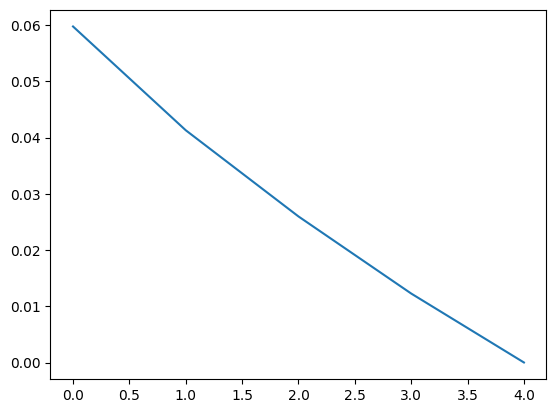

In [40]:
plt.plot(metrics["mask_sensorial_train"])

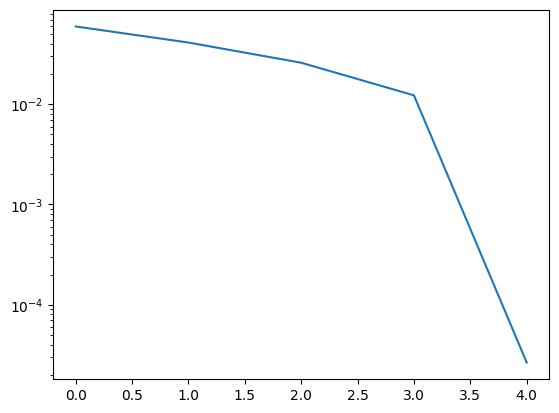

In [41]:
plt.plot(metrics["mask_sensorial_train"])
plt.yscale("log")

In [ ]:
s